## Чемпионат мира по футболу 2022 года

### Цель проекта

Смоделировать результаты Чемпионата Мира 2022 года по футболу на основе данных по матчам национальных сборных с 1872 года.

### Выполнение проекта

#### Знакомство с данными и общая информация

Импортируем библиотеки:

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_rows', 100)
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

Получим данные:

`Результаты матчей с 1872 по 2024 год`

In [2]:
results = pd.read_csv('results.csv', sep=',', dtype={'neutral' : int})
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,0
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,0
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,0


`ЧМ 2022 года`

In [3]:
WC_2022 = pd.read_csv('Fifa_world_cup_matches.csv', sep=',', parse_dates=['date'])
WC_2022.head()

,team1,team2,possession team1,possession team2,possession in contest,number of goals team1,number of goals team2,date,hour,category,...,penalties scored team1,penalties scored team2,goal preventions team1,goal preventions team2,own goals team1,own goals team2,forced turnovers team1,forced turnovers team2,defensive pressures applied team1,defensive pressures applied team2
0,QATAR,ECUADOR,42%,50%,8%,0,2,2022-11-20,17 : 00,Group A,...,0,1,6,5,0,0,52,72,256,279
1,ENGLAND,IRAN,72%,19%,9%,6,2,2022-11-21,14 : 00,Group B,...,0,1,8,13,0,0,63,72,139,416
2,SENEGAL,NETHERLANDS,44%,45%,11%,0,2,2022-11-21,17 : 00,Group A,...,0,0,9,15,0,0,63,73,263,251
3,UNITED STATES,WALES,51%,39%,10%,1,1,2022-11-21,20 : 00,Group B,...,0,1,7,7,0,0,81,72,242,292
4,ARGENTINA,SAUDI ARABIA,64%,24%,12%,1,2,2022-11-22,11 : 00,Group C,...,1,0,4,14,0,0,65,80,163,361


`Рейтинг сборных`

In [4]:
rating = pd.read_csv('fifa_ranking.csv', sep=',', parse_dates=['rank_date'])
rating.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


#### Предобработка данных

Нас интересует историческая информации только по тем сборным, которые участвовали на ЧМ 2022 года. Получим список этих сборных:

In [ ]:
teams = ['GERMANY', 'SWITZERLAND', '']

In [5]:
teams = WC_2022['team1'].unique().tolist()
len(teams)

32

In [6]:
teams

['QATAR',
 'ENGLAND',
 'SENEGAL',
 'UNITED STATES',
 'ARGENTINA',
 'DENMARK',
 'MEXICO',
 'FRANCE',
 'MOROCCO',
 'GERMANY',
 'SPAIN',
 'BELGIUM',
 'SWITZERLAND',
 'URUGUAY',
 'PORTUGAL',
 'BRAZIL',
 'WALES',
 'NETHERLANDS',
 'TUNISIA',
 'POLAND',
 'JAPAN',
 'CROATIA',
 'CAMEROON',
 'KOREA REPUBLIC',
 'ECUADOR',
 'IRAN',
 'AUSTRALIA',
 'SAUDI ARABIA',
 'CANADA',
 'COSTA RICA',
 'GHANA',
 'SERBIA']

32 команды, все по регламенту! Проверим информацию по этим сборным в нашей базе:

Для начала ограничим наши данные. Возьмем информацию с 2019 года:

In [1116]:
results['date'] = pd.to_datetime(results['date'])
results = results[results['date']>='2019-01-01']

In [1117]:
results['date'].sort_values().head()

41762   2019-01-02
41763   2019-01-05
41764   2019-01-06
41765   2019-01-06
41766   2019-01-06
Name: date, dtype: datetime64[ns]

Переведем названия стран в верхний регистр:

In [1118]:
results['home_team'] = results['home_team'].str.upper()
results['away_team'] = results['away_team'].str.upper()

Вычтем множества команд, которые встречаются в двух датасетах:

In [1119]:
set(teams) - set(results[results['home_team'].isin(teams)]['home_team'])

{'KOREA REPUBLIC'}

В базе нет *KOREA REPUBLIC*, может быть она называется как-то иначе? Поищем просто Корею:

In [1120]:
results['home_team'].str.contains("KOREA", case=True, flags=0, na=None, regex=True).sum()

49

Выведем найденные строки:

In [1121]:
results[results['home_team'].str.contains("KOREA")].head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
41768,2019-01-07,SOUTH KOREA,PHILIPPINES,1,0,AFC Asian Cup,Dubai,United Arab Emirates,1
41787,2019-01-13,NORTH KOREA,QATAR,0,6,AFC Asian Cup,Al Ain,United Arab Emirates,1
41795,2019-01-16,SOUTH KOREA,CHINA PR,2,0,AFC Asian Cup,Abu Dhabi,United Arab Emirates,1
41809,2019-01-22,SOUTH KOREA,BAHRAIN,2,1,AFC Asian Cup,Dubai,United Arab Emirates,1
41813,2019-01-25,SOUTH KOREA,QATAR,0,1,AFC Asian Cup,Abu Dhabi,United Arab Emirates,1


У нас есть `SOUTH KOREA`. Заменим значения:

In [1122]:
results['home_team'] = results['home_team'].str.replace('SOUTH KOREA', 'KOREA REPUBLIC')
results['away_team'] = results['away_team'].str.replace('SOUTH KOREA', 'KOREA REPUBLIC')

Снова проверим набор стран в датасетах:

In [1123]:
set(teams) - set(results[results['home_team'].isin(teams)]['home_team'])

set()

У нас есть информация по всем странам участникам ЧМ 2022!

In [1124]:
results[results['home_team'].isin(teams)].groupby('home_team')['home_team'].count().head()

home_team
ARGENTINA    39
AUSTRALIA    25
BELGIUM      30
BRAZIL       40
CAMEROON     30
Name: home_team, dtype: int64

Добавим рейтинг сборных в наш набор данных:

In [1125]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
41762,2019-01-02,OMAN,THAILAND,2,0,Friendly,Abu Dhabi,United Arab Emirates,1
41763,2019-01-05,UNITED ARAB EMIRATES,BAHRAIN,1,1,AFC Asian Cup,Abu Dhabi,United Arab Emirates,0
41764,2019-01-06,THAILAND,INDIA,1,4,AFC Asian Cup,Abu Dhabi,United Arab Emirates,1
41765,2019-01-06,AUSTRALIA,JORDAN,0,1,AFC Asian Cup,Al Ain,United Arab Emirates,1
41766,2019-01-06,SYRIA,PALESTINE,0,0,AFC Asian Cup,Sharjah,United Arab Emirates,1


In [1126]:
rating = rating[rating['rank_date']>='2018-06-01']
rating['country_full'] = rating['country_full'].str.upper()
rating.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
56347,166,PAPUA NEW GUINEA,PNG,103.0,78.0,-14,OFC,2018-06-07
56348,166,CAMBODIA,CAM,103.0,105.0,-4,AFC,2018-06-07
56349,155,MAURITIUS,MRI,140.0,124.0,-6,CAF,2018-06-07
56350,133,YEMEN,YEM,227.0,251.0,9,AFC,2018-06-07
56351,134,SWAZILAND,SWZ,222.0,240.0,3,CAF,2018-06-07


Проверим, есть ли у нас рейтинг по всем странам, которые участвовали в ЧМ:

In [1127]:
set(teams) - set(rating['country_full'])

{'IRAN', 'UNITED STATES'}

Поищем по аббревиатурам:

In [1128]:
rating[rating['country_full'].str.contains('USA')].head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
56477,25,USA,USA,873.0,880.0,1,CONCACAF,2018-06-07
56628,25,USA,USA,1905.0,1904.0,0,CONCACAF,2018-07-01
56818,22,USA,USA,1508.0,1508.0,-3,CONCACAF,2018-08-16
57121,22,USA,USA,1510.0,1508.0,0,CONCACAF,2018-09-20
57338,23,USA,USA,1506.0,1510.0,1,CONCACAF,2018-10-25


Переименуем США:

In [1129]:
rating['country_full'] = rating['country_full'].str.replace('USA', 'UNITED STATES')

Ищем Иран:

In [1130]:
rating[rating['country_abrv'].str.contains('IRN')].head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
56460,37,IR IRAN,IRN,708.0,727.0,1,AFC,2018-06-07
56631,28,IR IRAN,IRN,1896.0,1890.0,0,AFC,2018-07-01
56860,32,IR IRAN,IRN,1471.0,1460.0,-5,AFC,2018-08-16
57081,33,IR IRAN,IRN,1474.0,1471.0,1,AFC,2018-09-20
57291,30,IR IRAN,IRN,1478.0,1474.0,-3,AFC,2018-10-25


In [1131]:
rating['country_full'] = rating['country_full'].str.replace('IR IRAN', 'IRAN')

Возьмем среднее значения рейтинга с 2020 года по начало ЧМ (2022/11/20):

In [1132]:
avg_rating = rating[rating['rank_date']<'2022-11-20'].groupby('country_full')['rank'].mean().reset_index()
avg_rating.head()

,country_full,rank
0,AFGHANISTAN,149.250000
1,ALBANIA,64.194444
2,ALGERIA,43.944444
3,AMERICAN SAMOA,191.027778
4,ANDORRA,142.861111


Подтянем рейтинг в данные с результатами игр:

In [1133]:
results = results.merge(avg_rating, left_on='home_team', right_on='country_full').rename(columns={'rank' : 'rank_home'})
results = results.merge(avg_rating, left_on='away_team', right_on='country_full').rename(columns={'rank' : 'rank_away'})
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 0 to 4333
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4334 non-null   datetime64[ns]
 1   home_team       4334 non-null   object        
 2   away_team       4334 non-null   object        
 3   home_score      4334 non-null   int64         
 4   away_score      4334 non-null   int64         
 5   tournament      4334 non-null   object        
 6   city            4334 non-null   object        
 7   country         4334 non-null   object        
 8   neutral         4334 non-null   int32         
 9   country_full_x  4334 non-null   object        
 10  rank_home       4334 non-null   float64       
 11  country_full_y  4334 non-null   object        
 12  rank_away       4334 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(7)
memory usage: 457.1+ KB


Подтянули без пропусков, сказка. Посмотрим:

In [1134]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,country_full_x,rank_home,country_full_y,rank_away
0,2019-01-02,OMAN,THAILAND,2,0,Friendly,Abu Dhabi,United Arab Emirates,1,OMAN,81.527778,THAILAND,114.416667
1,2021-05-25,OMAN,THAILAND,1,0,Friendly,Dubai,United Arab Emirates,1,OMAN,81.527778,THAILAND,114.416667
2,2024-01-21,OMAN,THAILAND,0,0,AFC Asian Cup,Doha,Qatar,1,OMAN,81.527778,THAILAND,114.416667
3,2019-01-14,UNITED ARAB EMIRATES,THAILAND,1,1,AFC Asian Cup,Al Ain,United Arab Emirates,0,UNITED ARAB EMIRATES,71.500000,THAILAND,114.416667
4,2021-06-07,UNITED ARAB EMIRATES,THAILAND,3,1,FIFA World Cup qualification,Dubai,United Arab Emirates,0,UNITED ARAB EMIRATES,71.500000,THAILAND,114.416667


Удалим лишние колонки:

In [1135]:
results.drop(columns=['country_full_x', 'country_full_y'], inplace=True)

In [1136]:
results

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_home,rank_away
0,2019-01-02,OMAN,THAILAND,2,0,Friendly,Abu Dhabi,United Arab Emirates,1,81.527778,114.416667
1,2021-05-25,OMAN,THAILAND,1,0,Friendly,Dubai,United Arab Emirates,1,81.527778,114.416667
2,2024-01-21,OMAN,THAILAND,0,0,AFC Asian Cup,Doha,Qatar,1,81.527778,114.416667
3,2019-01-14,UNITED ARAB EMIRATES,THAILAND,1,1,AFC Asian Cup,Al Ain,United Arab Emirates,0,71.500000,114.416667
4,2021-06-07,UNITED ARAB EMIRATES,THAILAND,3,1,FIFA World Cup qualification,Dubai,United Arab Emirates,0,71.500000,114.416667
...,...,...,...,...,...,...,...,...,...,...,...
4329,2023-11-18,NEW CALEDONIA,TONGA,7,0,Pacific Games,Honiara,Solomon Islands,1,155.555556,202.428571
4330,2023-11-30,SAMOA,COOK ISLANDS,3,0,Pacific Games,Solomon Islands,Solomon Islands,1,194.361111,190.133333
4331,2023-08-28,TAHITI,COOK ISLANDS,9,1,Friendly,Pirae,Tahiti,0,159.500000,190.133333
4332,2023-08-31,TAHITI,COOK ISLANDS,3,0,Friendly,Pirae,Tahiti,0,159.500000,190.133333


Добавим в данные **процент побед** за выбранный период:

In [1137]:
results_c = results.loc[(results['tournament']!='Friendly')&(results['date']<'2022-11-20')]

In [1138]:
avg_wins_list = []
for team in teams:
    res_team_home = results_c.loc[(results['home_team']==team)]
    res_away_home = results_c.loc[(results['away_team']==team)]
    wins = len(res_team_home[res_team_home['home_score']>res_team_home['away_score']]) + \
            len(res_away_home[res_away_home['home_score']<res_away_home['away_score']])
    avg_wins_list.append(wins / (len(res_team_home) + len(res_away_home)))
#     print(team, wins / (len(res_team_home) + len(res_away_home)))

In [1139]:
avg_wins = pd.DataFrame(index=teams, data=avg_wins_list).reset_index().rename(columns={'index' : 'team', 0 : 'avg_wins'})
avg_wins.head()

,team,avg_wins
0,QATAR,0.687500
1,ENGLAND,0.589744
2,SENEGAL,0.615385
3,UNITED STATES,0.676471
4,ARGENTINA,0.656250


In [1140]:
results = results.merge(avg_wins, left_on='home_team', right_on='team').rename(columns={'avg_wins' : 'avg_wins_home'})
results = results.merge(avg_wins, left_on='away_team', right_on='team').rename(columns={'avg_wins' : 'avg_wins_away'})

Отметим, что признаки с рейтингами являются ключами, по которым мы можем определить страну. Тогда можем использовать при построении моделей именно признаки rank_home и rank_away. Выделим необходимые нам столбцы:



In [1141]:
data_home = results[results['date']<'2022-11-20'][['home_score', 'neutral', 'rank_home', 'rank_away', 
                                                   'avg_wins_home', 'avg_wins_away']]
data_away = results[results['date']<'2022-11-20'][['away_score', 'neutral', 'rank_home', 'rank_away', 
                                                   'avg_wins_home', 'avg_wins_away']]
data_test = results[results['tournament']=='FIFA World Cup']
data_test = data_test[data_test['date']>='2022-11-20']

Будем отдельно предсказывать кол-во забитых голов для **домашней** и **гостевой** команд:

#### Построение моделей

In [1142]:
from sklearn.linear_model import LinearRegression

Введем модель:

In [1143]:
model_home = GradientBoostingRegressor()
model_away = GradientBoostingRegressor()

Выделяем `X`, `y` для домашних команд:

In [1144]:
X_train_home = data_home[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']]
y_train_home = data_home['home_score']

Выделяем `X`, `y` для гостевых команд:

In [1145]:
X_train_away = data_away[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']]
y_train_away = data_away['away_score']

По тестовой выборке формируем наши признаки для предсказаний и записываем реальные результаты с названиями команд для будущей проверки:

In [1146]:
cols_with_teams_and_results = data_test[['home_team', 'away_team', 'home_score', 'away_score']]
X_test = data_test[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']]

**Обучаем модели:**

In [1147]:
model_home.fit(X_train_home, y_train_home)
model_away.fit(X_train_away, y_train_away)

GradientBoostingRegressor()

Получаем предсказания:

In [1148]:
home_score_predict = model_home.predict(X_test)
away_score_predict = model_away.predict(X_test)

Добавляем их в датасет с реальными результатами:

In [1149]:
cols_with_teams_and_results['home_score_predict'] = home_score_predict
cols_with_teams_and_results['away_score_predict'] = away_score_predict

Смотрим на результат:

In [1150]:
cols_with_teams_and_results

,home_team,away_team,home_score,away_score,home_score_predict,away_score_predict
5,GERMANY,JAPAN,1,2,0.991020,1.567400
15,ARGENTINA,SAUDI ARABIA,1,2,3.128278,-0.242334
16,POLAND,SAUDI ARABIA,2,0,1.394772,0.677140
22,ARGENTINA,AUSTRALIA,2,1,3.202063,0.088704
26,TUNISIA,AUSTRALIA,0,1,0.361307,1.013207
27,FRANCE,AUSTRALIA,4,1,3.412568,1.104378
43,ENGLAND,IRAN,6,2,2.304923,1.665192
44,WALES,IRAN,0,2,0.711012,1.969085
46,JAPAN,COSTA RICA,0,1,1.211371,0.608673
57,SPAIN,COSTA RICA,7,0,2.378467,0.532362


Оценим по *MSE*:

Первая команда:

In [1151]:
mean_squared_error(home_score_predict, cols_with_teams_and_results['home_score'])

2.428775698560412

Вторая модель:

In [1152]:
mean_squared_error(away_score_predict, cols_with_teams_and_results['away_score'])

2.101507319823995

Чтобы оценить модель, добавим классификатор победы домашней команды:

In [1153]:
cols_with_teams_and_results['is_home_win'] = cols_with_teams_and_results['home_score'] > \
                                            cols_with_teams_and_results['away_score']

Сделаем также по нашим предсказаниям:

In [1154]:
cols_with_teams_and_results['is_home_win_predict'] = cols_with_teams_and_results['home_score_predict'] > \
                                            cols_with_teams_and_results['away_score_predict']

Переведем в тип данных `int`:

In [1155]:
cols_with_teams_and_results[['is_home_win','is_home_win_predict']] = \
            cols_with_teams_and_results[['is_home_win','is_home_win_predict']].astype(int)

Оценим метрики:

In [1156]:
from sklearn.metrics import accuracy_score

In [1157]:
accuracy_score(cols_with_teams_and_results['is_home_win'], cols_with_teams_and_results['is_home_win_predict'])

0.671875

**Оптимизация гиперпарметров:**

Напишем функцию, которая оптимизирует гиперпараметры выбранной модели:

In [1158]:
from sklearn.linear_model import Ridge

In [1159]:
def optimaze_par(model, grid, X, y):
    grid_model = GridSearchCV(estimator=model,
                            param_grid=grid,
                            scoring='neg_mean_squared_error',
                            cv=5,
                            verbose=1)
    grid_model.fit(X, y)

    return grid_model.best_estimator_


`Ridge`

In [1160]:
optimaze_par(Ridge(), {'alpha' : [20, 100, 110, 150]}, X_train_home, y_train_home)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Ridge(alpha=20)

Для первой команды:

In [1161]:
preds_home = Ridge(alpha=110).fit(X_train_home, y_train_home).predict(X_test)
mean_squared_error(preds_home, cols_with_teams_and_results['home_score'])

2.158164501005589

Для второй команды:

In [1162]:
preds_away = Ridge(alpha=110).fit(X_train_away, y_train_away).predict(X_test)
mean_squared_error(preds_away, cols_with_teams_and_results['away_score'])

1.1355844024868547

`Lasso`

In [1163]:
from sklearn.linear_model import Lasso

In [1164]:
optimaze_par(Lasso(), {'alpha' : [1, 5, 10, 15]}, X_train_home, y_train_home)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Lasso(alpha=1)

Для первой команды:

In [1165]:
preds_home = Lasso(alpha=1).fit(X_train_home, y_train_home).predict(X_test)
mean_squared_error(preds_home, cols_with_teams_and_results['home_score'])

2.174716948588012

Для второй команды:

In [1166]:
preds_away = Lasso(alpha=1).fit(X_train_away, y_train_away).predict(X_test)
mean_squared_error(preds_away, cols_with_teams_and_results['away_score'])

1.1229833445104977

`GradientBoostingRegressor`

In [1167]:
optimaze_par(GradientBoostingRegressor(), {'min_samples_split' : [2, 4, 6], 'min_samples_leaf' : [1, 2, 4],
                                    'max_depth' : [1, 3, 5]}, X_train_home, y_train_home)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GradientBoostingRegressor(max_depth=1, min_samples_leaf=4, min_samples_split=6)

Для первой команды:

In [1199]:
preds_home = GradientBoostingRegressor(max_depth=1, min_samples_leaf=4, min_samples_split=6).fit(X_train_home, y_train_home).predict(X_test)
mean_squared_error(preds_home, cols_with_teams_and_results['home_score'])

2.0972921762197467

Для второй команды:

In [1200]:
preds_away = GradientBoostingRegressor(max_depth=1, min_samples_leaf=4, min_samples_split=6).fit(X_train_away, y_train_away).predict(X_test)
mean_squared_error(preds_away, cols_with_teams_and_results['away_score'])

1.2523594103796643

`HistGradientBoostingRegressor`

In [1170]:
optimaze_par(HistGradientBoostingRegressor(), { 'min_samples_leaf' : [1, 2, 4],
                                    'max_depth' : [1, 3, 5]}, X_train_home, y_train_home)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


HistGradientBoostingRegressor(max_depth=1, min_samples_leaf=1)

Для первой команды:

In [1171]:
preds_home = HistGradientBoostingRegressor(max_depth=1, min_samples_leaf=1).fit(X_train_home, y_train_home).predict(X_test)
mean_squared_error(preds_home, cols_with_teams_and_results['home_score'])

2.097292177488889

Для второй команды:

In [1172]:
preds_away = HistGradientBoostingRegressor(max_depth=1, min_samples_leaf=1).fit(X_train_away, y_train_away).predict(X_test)
mean_squared_error(preds_away, cols_with_teams_and_results['away_score'])

1.2523594100349862

Лучшие модели по метрикам:

In [1173]:
preds_home = GradientBoostingRegressor(max_depth=1).fit(X_train_home, y_train_home).predict(X_test)
preds_away = Lasso(alpha=1).fit(X_train_away, y_train_away).predict(X_test)

Посмотрим на графики:

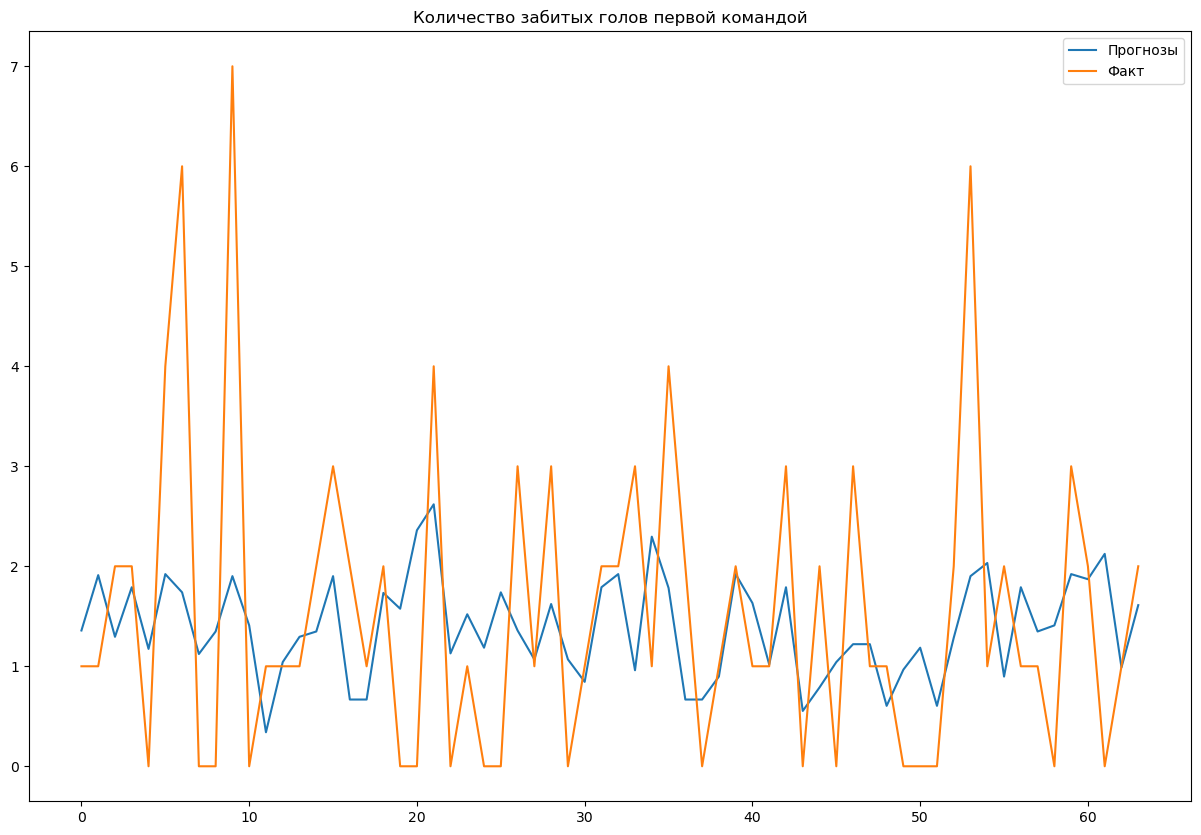

In [1174]:
plt.figure(figsize=(15, 10))
plt.plot(preds_home, label='Прогнозы')
plt.plot(cols_with_teams_and_results['home_score'].tolist(), label='Факт')

plt.title('Количество забитых голов первой командой')
plt.legend()
plt.show()

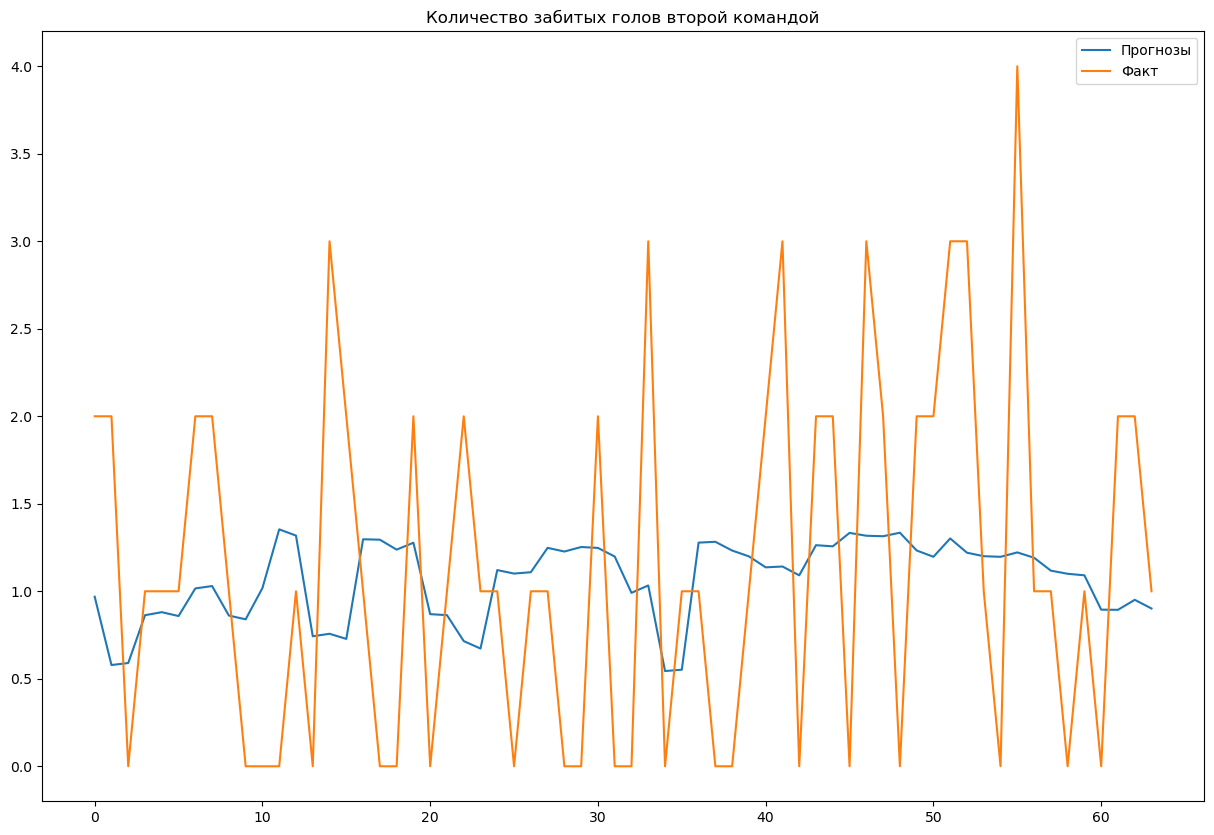

In [1175]:
plt.figure(figsize=(15, 10))
plt.plot(preds_away, label='Прогнозы')
plt.plot(cols_with_teams_and_results['away_score'].tolist(), label='Факт')

plt.title('Количество забитых голов второй командой')
plt.legend()
plt.show()

**Моделируем ЧМ2022**

Введем итоговые модели:

In [1176]:
model_home = GradientBoostingRegressor(max_depth=1).fit(X_train_home, y_train_home)

In [1177]:
model_away = Lasso(alpha=1).fit(X_train_away, y_train_away)

Создадим группы:

In [1178]:
groups = {}
for group in WC_2022['category'].unique().tolist()[:8]:
    teams = WC_2022[WC_2022['category']==group]['team1'].unique().tolist()
    groups[group] = pd.DataFrame(index=teams, columns=['М', 'В', 'Н', 'П', 'ГЗ', 'ГП', 'О']).fillna(0)
    

In [1179]:
groups['Group A']

,М,В,Н,П,ГЗ,ГП,О
QATAR,0,0,0,0,0,0,0
SENEGAL,0,0,0,0,0,0,0
NETHERLANDS,0,0,0,0,0,0,0
ECUADOR,0,0,0,0,0,0,0


Добавим к расписанию матчей группу жеребьевки:

In [1180]:
data_test = data_test.merge(WC_2022[['team1', 'team2', 'category']], left_on=['home_team', 'away_team'], 
               right_on=['team1', 'team2'], how='left').sort_values('date').drop(columns=['team1', 'team2']).fillna('Group A')
data_test.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_home,rank_away,team_x,avg_wins_home,team_y,avg_wins_away,category
22,2022-11-20,QATAR,ECUADOR,0,2,FIFA World Cup,Al Khor,Qatar,0,61.805556,56.305556,QATAR,0.687500,ECUADOR,0.259259,Group A
57,2022-11-21,UNITED STATES,WALES,1,1,FIFA World Cup,Al Rayyan,Qatar,1,20.166667,19.916667,UNITED STATES,0.676471,WALES,0.470588,Group B
50,2022-11-21,SENEGAL,NETHERLANDS,0,2,FIFA World Cup,Doha,Qatar,1,21.000000,13.416667,SENEGAL,0.615385,NETHERLANDS,0.694444,Group A
6,2022-11-21,ENGLAND,IRAN,6,2,FIFA World Cup,Al Rayyan,Qatar,1,4.666667,27.194444,ENGLAND,0.589744,IRAN,0.750000,Group B
10,2022-11-22,DENMARK,TUNISIA,0,0,FIFA World Cup,Al Rayyan,Qatar,1,11.861111,27.555556,DENMARK,0.638889,TUNISIA,0.567568,Group D


Моделируем групповой этап:

In [1181]:
for group in list(groups.keys()):
    matches = data_test[data_test['category']==group].reset_index().drop('index', axis=1)
    home_goals = model_home.predict(matches[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
    away_goals = model_away.predict(matches[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
    for i in range(len(matches)):
        t1 = matches.iloc[i, 1]
        t2 = matches.iloc[i, 2]
        
        groups[group].loc[t1, 'М'] += 1
        groups[group].loc[t2, 'М'] += 1
        
        groups[group].loc[t1, 'ГЗ'] += round(home_goals[i])
        groups[group].loc[t2, 'ГЗ'] += round(away_goals[i])
        
        groups[group].loc[t1, 'В'] += home_goals[i] > away_goals[i] + 0.1
        groups[group].loc[t2, 'В'] += home_goals[i] + 0.1 < away_goals[i]
        
        groups[group].loc[t1, 'П'] += home_goals[i] + 0.1 < away_goals[i]
        groups[group].loc[t2, 'П'] += home_goals[i] > away_goals[i] + 0.1
        
        groups[group].loc[t1, 'Н'] += abs(home_goals[i] - away_goals[i]) <= 0.1
        groups[group].loc[t2, 'Н'] += abs(home_goals[i] - away_goals[i]) <= 0.1
        
        groups[group].loc[t1, 'О'] +=  (home_goals[i] > away_goals[i] + 0.1) * 3 + (abs(home_goals[i] - away_goals[i]) <= 0.1)
        groups[group].loc[t2, 'О'] += (home_goals[i] + 0.1 < away_goals[i]) * 3 + (abs(home_goals[i] - away_goals[i]) <= 0.1)
        
        
        groups[group].loc[t1, 'ГП'] += round(away_goals[i])
        groups[group].loc[t2, 'ГП'] += round(home_goals[i])
        
        groups[group] = groups[group].sort_values(['О', 'ГЗ'], ascending=False)
        
        

In [1182]:
for group in groups:
    display(groups[group])

,М,В,Н,П,ГЗ,ГП,О
NETHERLANDS,3,2,1,0,4,3,7
SENEGAL,3,1,1,1,3,4,4
ECUADOR,3,1,0,2,4,4,3
QATAR,3,1,0,2,3,3,3


,М,В,Н,П,ГЗ,ГП,О
ENGLAND,3,3,0,0,5,3,9
UNITED STATES,3,1,1,1,3,4,4
IRAN,3,0,2,1,3,4,2
WALES,3,0,1,2,3,3,1


,М,В,Н,П,ГЗ,ГП,О
ARGENTINA,3,3,0,0,5,3,9
MEXICO,3,2,0,1,3,4,6
POLAND,3,1,0,2,3,3,3
SAUDI ARABIA,3,0,0,3,3,4,0


,М,В,Н,П,ГЗ,ГП,О
FRANCE,3,3,0,0,5,3,9
DENMARK,3,2,0,1,3,4,6
TUNISIA,3,1,0,2,3,3,3
AUSTRALIA,3,0,0,3,3,4,0


,М,В,Н,П,ГЗ,ГП,О
BELGIUM,3,3,0,0,5,3,9
CROATIA,3,2,0,1,4,3,6
CANADA,3,0,1,2,3,5,1
MOROCCO,3,0,1,2,3,4,1


,М,В,Н,П,ГЗ,ГП,О
SPAIN,3,3,0,0,5,3,9
GERMANY,3,2,0,1,3,4,6
JAPAN,3,1,0,2,3,3,3
COSTA RICA,3,0,0,3,3,4,0


,М,В,Н,П,ГЗ,ГП,О
BRAZIL,3,3,0,0,5,2,9
SWITZERLAND,3,1,1,1,3,4,4
SERBIA,3,0,2,1,3,4,2
CAMEROON,3,0,1,2,2,3,1


,М,В,Н,П,ГЗ,ГП,О
PORTUGAL,3,3,0,0,5,3,9
URUGUAY,3,1,0,2,4,5,3
GHANA,3,1,0,2,4,4,3
KOREA REPUBLIC,3,1,0,2,3,4,3


Моделируем 1/8 ЧМ2022:

In [1183]:
matches_1_8 = pd.DataFrame(columns=['home_team', 'away_team'])
matches_1_8.loc[0, :] = [groups['Group A'].index[0], groups['Group B'].index[1]]
matches_1_8.loc[1, :] = [groups['Group C'].index[0], groups['Group D'].index[1]]
matches_1_8.loc[2, :] = [groups['Group E'].index[0], groups['Group F'].index[1]]
matches_1_8.loc[3, :] = [groups['Group G'].index[0], groups['Group H'].index[1]]

matches_1_8.loc[4, :] = [groups['Group B'].index[0], groups['Group A'].index[1]]
matches_1_8.loc[5, :] = [groups['Group D'].index[0], groups['Group C'].index[1]]
matches_1_8.loc[6, :] = [groups['Group F'].index[0], groups['Group E'].index[1]]
matches_1_8.loc[7, :] = [groups['Group H'].index[0], groups['Group G'].index[1]]

In [1184]:
matches_1_8['neutral'] = 1
matches_1_8 = matches_1_8.merge(data_test[['home_team', 'rank_home', 'avg_wins_home']].drop_duplicates(), on='home_team', how='left')
matches_1_8 = matches_1_8.merge(data_test[['away_team', 'rank_away', 'avg_wins_away']].drop_duplicates(), on='away_team', how='left')
matches_1_8

,home_team,away_team,neutral,rank_home,avg_wins_home,rank_away,avg_wins_away
0,NETHERLANDS,UNITED STATES,1,13.416667,0.694444,20.166667,0.676471
1,ARGENTINA,DENMARK,1,7.916667,0.656250,11.861111,0.638889
2,SPAIN,CROATIA,1,7.500000,0.605263,9.972222,0.529412
3,BRAZIL,URUGUAY,1,2.583333,0.741935,8.972222,0.444444
4,ENGLAND,SENEGAL,1,4.666667,0.589744,21.000000,0.615385
5,FRANCE,MEXICO,1,2.500000,0.611111,12.333333,0.636364
6,BELGIUM,GERMANY,1,1.305556,0.756757,12.888889,0.588235
7,PORTUGAL,SWITZERLAND,1,6.500000,0.611111,12.083333,0.428571


In [1185]:
matches_1_8['home_goals'] = model_home.predict(matches_1_8[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
matches_1_8['away_goals'] = model_away.predict(matches_1_8[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
matches_1_8['next_round'] = matches_1_8[['home_team', 'away_team', 'home_goals' , 'away_goals']].apply(lambda x: 
                                                                                    x[0] if x[2] > x[3] else x[1], axis=1)


In [1186]:
matches_1_8

,home_team,away_team,neutral,rank_home,avg_wins_home,rank_away,avg_wins_away,home_goals,away_goals,next_round
0,NETHERLANDS,UNITED STATES,1,13.416667,0.694444,20.166667,0.676471,1.357917,1.108925,NETHERLANDS
1,ARGENTINA,DENMARK,1,7.916667,0.656250,11.861111,0.638889,1.790367,1.204344,ARGENTINA
2,SPAIN,CROATIA,1,7.500000,0.605263,9.972222,0.529412,1.622565,1.226781,SPAIN
3,BRAZIL,URUGUAY,1,2.583333,0.741935,8.972222,0.444444,1.865014,1.234514,BRAZIL
4,ENGLAND,SENEGAL,1,4.666667,0.589744,21.000000,0.615385,1.790367,1.091140,ENGLAND
5,FRANCE,MEXICO,1,2.500000,0.611111,12.333333,0.636364,1.921702,1.193861,FRANCE
6,BELGIUM,GERMANY,1,1.305556,0.756757,12.888889,0.588235,2.175027,1.186100,BELGIUM
7,PORTUGAL,SWITZERLAND,1,6.500000,0.611111,12.083333,0.428571,1.901481,1.200411,PORTUGAL


Моделируем 1/4 ЧМ2022:

In [1187]:
matches_1_4 = pd.DataFrame(columns=['home_team', 'away_team'])
matches_1_4.loc[0, :] = [matches_1_8.loc[0, 'next_round'], matches_1_8.loc[1, 'next_round']]
matches_1_4.loc[1, :] = [matches_1_8.loc[2, 'next_round'], matches_1_8.loc[3, 'next_round']]
matches_1_4.loc[2, :] = [matches_1_8.loc[4, 'next_round'], matches_1_8.loc[5, 'next_round']]
matches_1_4.loc[3, :] = [matches_1_8.loc[6, 'next_round'], matches_1_8.loc[7, 'next_round']]
matches_1_4

,home_team,away_team
0,NETHERLANDS,ARGENTINA
1,SPAIN,BRAZIL
2,ENGLAND,FRANCE
3,BELGIUM,PORTUGAL


In [1188]:
matches_1_4['neutral'] = 1
matches_1_4 = matches_1_4.merge(data_test[['home_team', 'rank_home', 'avg_wins_home']].drop_duplicates(), on='home_team', how='left')
matches_1_4 = matches_1_4.merge(data_test[['away_team', 'rank_away', 'avg_wins_away']].drop_duplicates(), on='away_team', how='left')

In [1189]:
matches_1_4['home_goals'] = model_home.predict(matches_1_4[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
matches_1_4['away_goals'] = model_away.predict(matches_1_4[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
matches_1_4['next_round'] = matches_1_4[['home_team', 'away_team', 'home_goals' , 'away_goals']].apply(lambda x: 
                                                                                    x[0] if x[2] > x[3] else x[1], axis=1)

In [1190]:
matches_1_4

,home_team,away_team,neutral,rank_home,avg_wins_home,rank_away,avg_wins_away,home_goals,away_goals,next_round
0,NETHERLANDS,ARGENTINA,1,13.416667,0.694444,7.916667,0.656250,0.788545,1.256822,ARGENTINA
1,SPAIN,BRAZIL,1,7.500000,0.605263,2.583333,0.741935,1.169997,1.315988,BRAZIL
2,ENGLAND,FRANCE,1,4.666667,0.589744,2.500000,0.611111,1.220995,1.314493,FRANCE
3,BELGIUM,PORTUGAL,1,1.305556,0.756757,6.500000,0.611111,1.605655,1.263234,BELGIUM


Моделируем 1/2 ЧМ2022:

In [1191]:
matches_1_2 = pd.DataFrame(columns=['home_team', 'away_team'])
matches_1_2.loc[0, :] = [matches_1_4.loc[0, 'next_round'], matches_1_4.loc[1, 'next_round']]
matches_1_2.loc[1, :] = [matches_1_4.loc[2, 'next_round'], matches_1_4.loc[3, 'next_round']]
matches_1_2

,home_team,away_team
0,ARGENTINA,BRAZIL
1,FRANCE,BELGIUM


In [1192]:
matches_1_2['neutral'] = 1
matches_1_2 = matches_1_2.merge(data_test[['home_team', 'rank_home', 'avg_wins_home']].drop_duplicates(), on='home_team', how='left')
matches_1_2 = matches_1_2.merge(data_test[['away_team', 'rank_away', 'avg_wins_away']].drop_duplicates(), on='away_team', how='left')

In [1193]:
matches_1_2['home_goals'] = model_home.predict(matches_1_2[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
matches_1_2['away_goals'] = model_away.predict(matches_1_2[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
matches_1_2['next_round'] = matches_1_2[['home_team', 'away_team', 'home_goals' , 'away_goals']].apply(lambda x: 
                                                                                    x[0] if x[2] > x[3] else x[1], axis=1)

In [1194]:
matches_1_2

,home_team,away_team,neutral,rank_home,avg_wins_home,rank_away,avg_wins_away,home_goals,away_goals,next_round
0,ARGENTINA,BRAZIL,1,7.916667,0.656250,2.583333,0.741935,1.169997,1.316356,BRAZIL
1,FRANCE,BELGIUM,1,2.500000,0.611111,1.305556,0.756757,1.301332,1.327001,BELGIUM


**ФИНАЛИЩЕ**

In [1195]:
matches_1 = pd.DataFrame(columns=['home_team', 'away_team'])
matches_1.loc[0, :] = [matches_1_2.loc[0, 'next_round'], matches_1_2.loc[1, 'next_round']]

In [1196]:
matches_1['neutral'] = 1
matches_1 = matches_1.merge(data_test[['home_team', 'rank_home', 'avg_wins_home']].drop_duplicates(), on='home_team', how='left')
matches_1 = matches_1.merge(data_test[['away_team', 'rank_away', 'avg_wins_away']].drop_duplicates(), on='away_team', how='left')
matches_1

,home_team,away_team,neutral,rank_home,avg_wins_home,rank_away,avg_wins_away
0,BRAZIL,BELGIUM,1,2.583333,0.741935,1.305556,0.756757


In [1197]:
matches_1['home_goals'] = model_home.predict(matches_1[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
matches_1['away_goals'] = model_away.predict(matches_1[['neutral', 'rank_home', 'rank_away', 'avg_wins_home', 'avg_wins_away']])
matches_1['THE WINNER'] = matches_1[['home_team', 'away_team', 'home_goals' , 'away_goals']].apply(lambda x: 
                                                                                    x[0] if x[2] > x[3] else x[1], axis=1)

In [1198]:
matches_1

,home_team,away_team,neutral,rank_home,avg_wins_home,rank_away,avg_wins_away,home_goals,away_goals,THE WINNER
0,BRAZIL,BELGIUM,1,2.583333,0.741935,1.305556,0.756757,1.301332,1.327075,BELGIUM


### Выводы

Первым делом мы **загрузили** все наши датасеты и провели их **предобработку**. Затем, мы занялись **интеграцией** данных и объединили нужную информацию в один датасет. Переходя к этапу **построения моделей**, мы **оптимизировали гиперпараметры** разных моделей и выбрали наилучшую. В завершении нашей работы мы **провели ЧМ2022**, не выходя из дома.